# **Dataset Preprocess**


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('creditcard.csv')

# Check for missing values in the 'Class' column
print("Missing values in 'Class' column:", data['Class'].isnull().sum())

# Drop rows where 'Class' is NaN
data = data.dropna(subset=['Class'])

# Re-check to confirm no more NaNs in 'Class'
print("Missing values in 'Class' column after dropping rows:", data['Class'].isnull().sum())


# Normalize 'Time' and 'Amount' using StandardScaler
scaler = StandardScaler()
data['NormalizedTime'] = scaler.fit_transform(data[['Time']])
data['NormalizedAmount'] = scaler.fit_transform(data[['Amount']])
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Split the dataset
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Missing values in 'Class' column: 0
Missing values in 'Class' column after dropping rows: 0


# ** Data Augmentation with Geometric Distribution Masks**

In [45]:
def apply_geometric_mask(data, mask_prob=0.1):
    mask = np.random.geometric(p=mask_prob, size=data.shape)
    masked_data = np.where(mask > 1, data, 0)  # Apply mask where mask > 1
    return masked_data

# Apply masks to the training data
X_train_masked = apply_geometric_mask(X_train.values)


# **Transformer-Based Autoencoder**

In [46]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_size, feature_size=256, num_heads=4, num_layers=1, forward_expansion=4, dropout=0.1):
        super(TransformerAutoencoder, self).__init__()
        # Ensure feature_size is a multiple of num_heads
        assert feature_size % num_heads == 0, "feature_size must be divisible by num_heads"

        self.embedding = nn.Linear(input_size, feature_size)  # Adjust input feature size to transformer feature size
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size,
            nhead=num_heads,
            dim_feedforward=feature_size * forward_expansion,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=feature_size,
            nhead=num_heads,
            dim_feedforward=feature_size * forward_expansion,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(feature_size, input_size)  # Map back to the original input size

    def forward(self, src):
        src = self.embedding(src)  # Embed input features
        encoded = self.encoder(src)
        decoded = self.decoder(encoded, encoded)
        output = self.output_layer(decoded)  # Map back to original feature space
        return output

# Use this to initialize your model
input_size = X_train.shape[1]
feature_size = 256  # Choose a feature size that is a multiple of num_heads
num_heads = 4
model = TransformerAutoencoder(input_size, feature_size, num_heads).to(device)

In [50]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train_masked and y_train are already defined and appropriately processed
train_dataset = TensorDataset(torch.tensor(X_train_masked, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
import torch.optim as optim

criterion = nn.MSELoss()  # For reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in train_loader:  # Labels are not used during training
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            avg_loss=total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Average Loss: 0.2997524391185833
Epoch 2, Average Loss: 0.6956491341079123
Epoch 3, Average Loss: 0.28350231071847526
Epoch 4, Average Loss: 0.1433485048947174
Epoch 5, Average Loss: 0.11341660927414576
Epoch 6, Average Loss: 0.10900120821915774
Epoch 7, Average Loss: 0.0994759663450862
Epoch 8, Average Loss: 0.10284824000943278
Epoch 9, Average Loss: 0.09021952378908464
Epoch 10, Average Loss: 0.08568075369468584


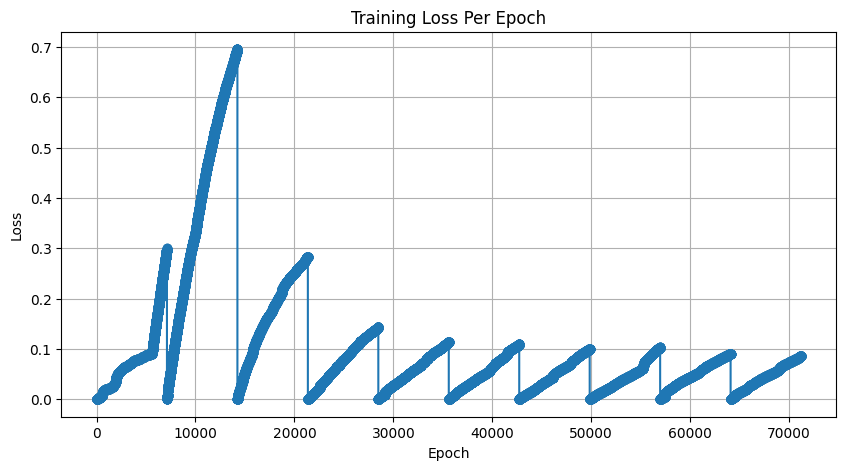

In [51]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, marker='o', linestyle='-')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# **GAN**

In [53]:
import torch
import torch.optim as optim
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

class Generator(nn.Module):
    def __init__(self, autoencoder_model):
        super(Generator, self).__init__()
        self.autoencoder = autoencoder_model

    def forward(self, x):
        return self.autoencoder(x)




# **Contrastive Loss for Anomoly Detection**

In [26]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, target, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output, target)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


# **Train GAN alongside with AutoEncoder**

In [25]:
def train_gan_autoencoder(autoencoder, generator, discriminator, data_loader, epochs=10):
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)
    optimizer_AE = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

    adversarial_loss = torch.nn.BCELoss()

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(data_loader):

            valid = torch.ones(imgs.size(0), 1, device=device, dtype=torch.float32)
            fake = torch.zeros(imgs.size(0), 1, device=device, dtype=torch.float32)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(imgs.shape[0], imgs.shape[1], device=device)
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # ---------------------
            #  Train Autoencoder
            # ---------------------
            optimizer_AE.zero_grad()
            reconstructed_imgs = autoencoder(imgs)
            ae_loss = torch.nn.functional.mse_loss(reconstructed_imgs, imgs)
            ae_loss.backward()
            optimizer_AE.step()

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [AE loss: %f]" %
                  (epoch, epochs, i, len(data_loader), d_loss.item(), g_loss.item(), ae_loss.item()))


In [70]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Device setup: CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Corrected input size
input_dim = 30  # Based on the shape of the data in your DataLoader

# Initialize models with correct input dimension
autoencoder_model = AutoencoderWithTransformer(input_size=input_dim, hidden_size=64, num_enc_layers=2, num_heads=1)
generator = Generator(autoencoder_model)
discriminator = Discriminator(input_dim=input_dim)

# Move models to the appropriate device
autoencoder_model.to(device)
generator.to(device)
discriminator.to(device)

# Data loader (assuming X_train_masked and y_train are available)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_masked, dtype=torch.float32),
                                        torch.tensor(y_train.values, dtype=torch.float32)),
                          batch_size=32, shuffle=True)

# Call the training function with the correct input size for discriminator
train_gan_autoencoder(autoencoder=autoencoder_model,
                      generator=generator,
                      discriminator=discriminator,
                      data_loader=train_loader,
                      epochs=10)  # Adjust the number of epochs as needed


[Epoch 0/10] [Batch 0/7121] [D loss: 0.692515] [G loss: 0.707324] [AE loss: 1.245325]
[Epoch 0/10] [Batch 1/7121] [D loss: 0.721692] [G loss: 0.643919] [AE loss: 1.027464]
[Epoch 0/10] [Batch 2/7121] [D loss: 0.722975] [G loss: 0.636395] [AE loss: 1.073896]
[Epoch 0/10] [Batch 3/7121] [D loss: 0.716805] [G loss: 0.640432] [AE loss: 1.797915]
[Epoch 0/10] [Batch 4/7121] [D loss: 0.710148] [G loss: 0.644775] [AE loss: 1.345544]
[Epoch 0/10] [Batch 5/7121] [D loss: 0.701391] [G loss: 0.653019] [AE loss: 0.845923]
[Epoch 0/10] [Batch 6/7121] [D loss: 0.689451] [G loss: 0.657893] [AE loss: 0.860108]
[Epoch 0/10] [Batch 7/7121] [D loss: 0.690890] [G loss: 0.660376] [AE loss: 1.675545]
[Epoch 0/10] [Batch 8/7121] [D loss: 0.681988] [G loss: 0.655757] [AE loss: 1.057407]
[Epoch 0/10] [Batch 9/7121] [D loss: 0.681187] [G loss: 0.649022] [AE loss: 1.028790]
[Epoch 0/10] [Batch 10/7121] [D loss: 0.688480] [G loss: 0.631985] [AE loss: 1.019851]
[Epoch 0/10] [Batch 11/7121] [D loss: 0.683966] [G lo

KeyboardInterrupt: 